# Import and Set Context

In [1]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [3]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Define Utility Functions

In [4]:
# Functions for map() or apply()

def get_word_count(x):
    '''
    Retun the number of words for the given text x.
    '''
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
        
def get_rate_change(x):
    '''
    Returns rate change decision of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['RateDecision']
    else:        
        return None

def get_rate(x):
    '''
    Returns rate of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
        
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['Rate']
    else:        
        return None

def get_next_meeting_date(x):
    '''
    Returns the next fomc meeting date for the given date x, referring to fomc_calendar DataFrame.
    Usually FOMC Meetings takes two days, so it starts searching from x+2.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None

    # Add two days to get the day after next
    x = x + dt.timedelta(days=2)
    
    # Just in case, sort fomc_calendar from older to newer
    fomc_calendar.sort_index(ascending=True, inplace=True)
    
    if fomc_calendar.index[0] > x:
        # If the date is older than the first FOMC Meeting, do not return any date.
        return None
    else:
        for i in range(len(fomc_calendar)):
            if x < fomc_calendar.index[i]:
                return fomc_calendar.index[i]
        # If x is greater than the newest FOMC meeting date, do not return any date.
        return None
    
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [5]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    return split_df

In [6]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatinate sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, remove the row.
    '''
    new_df = df.copy()
    new_text_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
        bk_text = ""
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
            elif num_words > 20:
                bk_text += " " + section
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text) # Fall back    
        else:
            new_text_list.append("")
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df.loc[new_df['word_count'] > 0]

def remove_short_nokeyword(df, keywords = ['rate', 'rates'], min_times=2, min_words=50):
    '''
    Drop sections which do not have any one of keywords for min_times times
     before applying remove_short_section()
    '''
    
    new_df = df.copy()
    new_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_section = []
                
        for section in row['text_sections']:
            if len(set(section.split()).intersection(keywords)) >= min_times:
                new_section.append(section)
        
        new_section_list.append(new_section)
    
    new_df['text_sections'] = new_section_list
    
    return remove_short_section(new_df, min_words=min_words)

# Load Data

### Chairpersons

In [7]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2022-02-05


### Load Calendar

In [8]:
file = open('../data/preprocessed/fomc_calendar.pickle', 'rb')

fomc_calendar = pickle.load(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

(359, 6)


,unscheduled,forecast,confcall,ChairPerson,Rate,RateDecision
date,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.500,-1.0
1982-11-16,False,False,False,Paul Volcker,9.000,-1.0
1982-12-21,False,False,False,Paul Volcker,8.500,0.0
1983-01-14,False,False,True,Paul Volcker,8.500,0.0
1983-01-21,False,False,True,Paul Volcker,8.500,0.0
1983-01-28,False,False,True,Paul Volcker,8.500,0.0
1983-02-09,False,False,False,Paul Volcker,8.500,0.0
1983-03-29,False,False,False,Paul Volcker,8.625,1.0
1983-04-29,False,False,True,Paul Volcker,8.625,0.0


### Statement

In [9]:
file = open('../data/FOMC/statement.pickle', 'rb')

statement_df = pickle.load(file)
file.close()

print(statement_df.shape)
statement_df

(196, 4)


,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement
5,1994-11-15,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",Alan Greenspan,FOMC Statement
6,1995-02-01,"\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 3/4 percent to 5 1/4 percent, effective immediately.\n\n[SEC...",Alan Greenspan,FOMC Statement
7,1995-07-06,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank re...,Alan Greenspan,FOMC Statement
8,1995-12-19,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve...,Alan Greenspan,FOMC Statement
9,1996-01-31,For immediate release\n\n\n\n\n\n\r\n\r\nThe Federal Reserve today announced the following policy \r\nactions:\r\n\r\n\nThe Board of Governors approved a reduction in the discount rate from \r\n5-...,Alan Greenspan,FOMC Statement


In [10]:
# Sample Contents - the 2nd last
print(statement_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Minutes

In [11]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pickle.load(file)
file.close()

print(minutes_df.shape)
minutes_df

(226, 4)


,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
5,1993-09-21,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, September 21, 1993, ...",Alan Greenspan,FOMC Meeting Minutes
6,1993-11-16,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, November 16, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
7,1993-12-21,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, December 21, 1993, at 9:...",Alan Greenspan,FOMC Meeting Minutes
8,1994-02-04,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Thursday, February 3, 1994, a...",Alan Greenspan,FOMC Meeting Minutes
9,1994-03-22,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",Alan Greenspan,FOMC Meeting Minutes


In [12]:
# Sample Contents - the 2nd last
print(minutes_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Transcripts

In [13]:
file = open('../data/FOMC/meeting_script.pickle', 'rb')

meeting_script_df = pickle.load(file)
file.close()

print(meeting_script_df.shape)
meeting_script_df

(200, 4)


,date,contents,speaker,title
0,1990-02-07,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...,Alan Greenspan,FOMC Meeting Transcript
1,1990-03-27,CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?\n\n[SECTION]\n\nMR. JOHNSON. Second.\n\n[SECTION]\n\nSPEAKER(?). It's too early to ...,Alan Greenspan,FOMC Meeting Transcript
2,1990-05-15,CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move them.\n\n[SECTION]\n\nMR. KELLEY. Second.\n\n[SECTION]\n\...,Alan Greenspan,FOMC Meeting Transcript
3,1990-07-03,"CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--\n\n[SECTION]\n\nVICE CHAIRMAN CORRIGAN. So move.\n\n[SECTION]\n\nSPEAKER(?). ...",Alan Greenspan,FOMC Meeting Transcript
4,1990-08-21,"CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes.\n\n[SECTION]\n\nSPEAKER(?). So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. ...",Alan Greenspan,FOMC Meeting Transcript
5,1990-10-02,"CHAIRMAN GREENSPAN. Good morning, everyone. Would somebodykindly move the minutes of the last FOMC meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Is ...",Alan Greenspan,FOMC Meeting Transcript
6,1990-11-13,CHAIRMAN GREENSPAN. Would somebody like to move approval ofthe minutes?\n\n[SECTION]\n\nMS. SEGER. I'll move.\n\n[SECTION]\n\nSPEAKER(?). Second.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. No...,Alan Greenspan,FOMC Meeting Transcript
7,1990-12-18,CHAIRMAN GREENSPAN. Would somebody like to move the minutesof the previous meeting?\n\n[SECTION]\n\nVICE CHAIRMAN CORRIGAN. So move.\n\n[SECTION]\n\nMR. SYRON. Second.\n\n[SECTION]\...,Alan Greenspan,FOMC Meeting Transcript
8,1991-02-06,"CHAIRMAN GREENSPAN. Good afternoon, everyone. Welcome, BobMcTeer; it's nice to see you at the table. You're sitting between twoformidable characters but I suspect you'll surviv...",Alan Greenspan,FOMC Meeting Transcript
9,1991-03-26,"CHAIRMAN GREENSPAN. This is the first time in a long timethat [the Committee membership] has been addressed as ""Messrs."" Whowould like to move approval of the minutes?\n\n[SECTIO...",Alan Greenspan,FOMC Meeting Transcript


In [14]:
# Sample Contents - the 2nd last
print(meeting_script_df['contents'].iloc[-1])

CHAIR YELLEN.  Good afternoon, everyone.  I think we are ready to begin.  The first item we are going to consider is in a joint Board and FOMC meeting, so I need a motion to close the Board meeting. 

[SECTION]

MR. FISCHER.  So moved. 

[SECTION]

CHAIR YELLEN.  Without objection, thank you.  I’m going to start off by calling on Simon to give us his report on market developments. 

[SECTION]

MR. POTTER.1  Thank you, Madam Chair.  Lorie and I will be splitting the Desk briefing into two parts.  I will discuss financial market developments and some issues related to open market operations.  After questions and answers on this section, Lorie will discuss testing and some related issues with supplementary normalization tools. Over the intermeeting period, U.S. economic data were generally viewed as positive and changes in financial conditions were mixed.  International developments were in focus with more-accommodative policy adopted or communicated by major central banks, driven by conc

### Press Conference Transcripts

In [15]:
file = open('../data/FOMC/presconf_script.pickle', 'rb')

presconf_script_df = pickle.load(file)
file.close()

print(presconf_script_df.shape)
presconf_script_df

(43, 4)


,date,contents,speaker,title
0,2011-04-27,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",Ben Bernanke,FOMC Press Conference Transcript
1,2011-06-22,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",Ben Bernanke,FOMC Press Conference Transcript
2,2011-11-02,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",Ben Bernanke,FOMC Press Conference Transcript
3,2012-01-25,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,Ben Bernanke,FOMC Press Conference Transcript
4,2012-04-25,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...",Ben Bernanke,FOMC Press Conference Transcript
5,2012-06-20,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then place the Committee’s appropriate path of moneta...",Ben Bernanke,FOMC Press Conference Transcript
6,2012-09-13,CHAIRMAN BERNANKE. Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our a...,Ben Bernanke,FOMC Press Conference Transcript
7,2012-12-12,"CHAIRMAN BERNANKE. Good afternoon. It’s been about three and a half years since the economic recovery began. The economy continues to expand at a moderate pace. Unfortunately, however, unemplo...",Ben Bernanke,FOMC Press Conference Transcript
8,2013-03-20,"CHAIRMAN BERNANKE. Good afternoon. The Federal Open Market Committee concluded a two-day meeting earlier today. As always, my colleagues and I reviewed recent economic and financial developmen...",Ben Bernanke,FOMC Press Conference Transcript
9,2013-06-19,"CHAIRMAN BERNANKE. Good afternoon. The Federal Open Market Committee concluded a two-day meeting earlier today. Based on its review of recent economic and financial developments, the Committee...",Ben Bernanke,FOMC Press Conference Transcript


In [16]:
# Sample Contents - the 2nd last
print(presconf_script_df['contents'].iloc[-1])

CHAIR POWELL.  Good afternoon.  Thanks for joining us today.  I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United States and around the world.  The coronavirus outbreak is first and foremost a public health crisis, and the most important response is coming from those in the front lines in hospitals, emergency services, and care facilities.  On behalf of the Federal Reserve, let me express our sincere gratitude to those dedicated individuals who put themselves at risk, day after day, in service to others and to our nation. The forceful measures that we as a country are taking to control the spread of the virus have brought much of the economy to an abrupt halt.  Many businesses have closed, people have been asked to stay home, and basic social interactions are greatly curtailed.  People are putting their lives and livelihoods on hold, at significant economic and personal cost.  All of us are affected, but th

### Speech

In [17]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pickle.load(file)
file.close()

print(speech_df.shape)
speech_df

(1461, 4)


,date,contents,speaker,title
0,1996-06-13,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",Chairman Alan Greenspan,Bank supervision in a world economy
1,1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...","Governor Edward W. Kelley, Jr.",Developments in electronic money and banking
2,1996-09-08,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,Governor Laurence H. Meyer,Monetary policy objectives and strategy
3,1996-09-19,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",Chairman Alan Greenspan,Regulation and electronic payment systems
4,1996-10-02,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",Governor Lawrence B. Lindsey,Small business is big business
5,1996-10-05,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\...",Chairman Alan Greenspan,"Bank supervision, regulation, and risk"
6,1996-10-07,"Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N...",Chairman Alan Greenspan,U.S. Treasury securities market: Lessons from Alexander Hamilton
7,1996-10-09,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan...",Governor Lawrence B. Lindsey,Here we go again?
8,1996-10-11,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHow To Grow Faster\n\n[SECTION]\n\nIt is my pleas...",Governor Lawrence B. Lindsey,How to grow faster
9,1996-10-16,"Remarks by Chairman Alan Greenspan\nTechnological advances and productivity\r\nAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New York\r\nOctober 16, 1996\n\n[SECTION]\n\...",Chairman Alan Greenspan,Technological advances and productivity


In [18]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Testimony

In [19]:
file = open('../data/FOMC/testimony.pickle', 'rb')

testimony_df = pickle.load(file)
file.close()

print(testimony_df.shape)
testimony_df

(436, 4)


,date,contents,speaker,title
0,1996-06-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...,"Governor Edward W. Kelley, Jr.",Supervision of bank sales practices
1,1996-07-17,"\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder...","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation","""Prime bank"" schemes"
2,1996-07-18,"Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT...",Chairman Alan Greenspan,The Federal Reserve's semiannual monetary report
3,1996-07-24,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...,Governor Janet L. Yellen,Trends in consumer lending
4,1996-07-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...,Chairman Alan Greenspan,Recent reports on Federal Reserve operations
5,1996-09-12,"\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Committee today to discuss trends in consumer\r\n\r\nlending, the Federal Reserve Board's vie...",Governor Lawrence B. Lindsey,Trends in consumer lending
6,1996-09-18,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nThank you for the opportunity to discuss the recent trading losses by Sumitomo Corporation and their implications for U.S. banks and markets. T...,Governor Susan M. Phillips,Implications of trading losses by Sumitomo Corp.
7,1997-01-21,"Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th...",Chairman Alan Greenspan,"January 21, 1997"
8,1997-01-30,"Testimony of Chairman Alan Greenspan\nThe consumer price index\r\nBefore the Committee on Finance, United States Senate\r\nJanuary 30, 1997\n\n[SECTION]\n\nMr. Chairman and members of the Committe...",Chairman Alan Greenspan,The comsumer price index
9,1997-02-13,Testimony of Chairman Alan Greenspan\nModernization of the financial system\r\nBefore the Subcommittee on Financial Institutions and Consumer Credit\r\n\tof the Committee on Banking and Financial ...,Chairman Alan Greenspan,Modernization of the financial system


In [20]:
# Sample Contents - the 2nd last
print(testimony_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

# Process the data

## Statements DataFrame

In [21]:
statement_df.head()

,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement


### Add Quantitative Easing as a Lower event

In [22]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.

if statement_df.loc[statement_df['date'] == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
              "to purchase the direct obligations of housing-related government-sponsored "\
              "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
              "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
              "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
              "have widened appreciably of late.  This action is being taken to reduce the cost "\
              "and increase the availability of credit for the purchase of houses, which in turn "\
              "should support housing markets and foster improved conditions in financial markets "\
              "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
              "the program will be conducted with the Federal Reserve's primary dealers through "\
              "a series of competitive auctions and will begin next week.  Purchases of up to "\
              "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
              "process with a goal of beginning these purchases before year-end.  "\
              "Purchases of both direct obligations and MBS are expected to take place over "\
              "several quarters.  Further information regarding the operational details of this "\
              "program will be provided after consultation with market participants."
    statement_df = statement_df.append(
        pd.Series([dt.datetime.strptime('2008-11-25', '%Y-%m-%d'), qe_text, 'Ben Bernanke', 'FOMC statement'], index=statement_df.columns),
        ignore_index=True
    )
    

### Create features

In [23]:
# Reorganize the dataframe
dict = {
    'type': "statement",
    'date': statement_df['date'],
    'title': statement_df['title'],
    'speaker': statement_df['speaker'],
    'word_count': statement_df['contents'].map(get_word_count),
    'decision': statement_df['date'].map(get_rate_change),
    'rate': statement_df['date'].map(get_rate),
    'next_meeting': statement_df['date'].map(get_next_meeting_date),
    'text': statement_df['contents'].map(lambda x: x.replace('\n','').replace('\r','')),
    'text_sections': statement_df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
    'org_text': statement_df['contents']
}

proc_statement_df = pd.DataFrame(dict)
print("No rate decision found: ", proc_statement_df['decision'].isnull().sum())
print("Shape of the dataframe: ", proc_statement_df.shape)
#proc_statement_df.dropna(subset=['decision'], axis=0, inplace=True)
proc_statement_df


No rate decision found:  41
Shape of the dataframe:  (197, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1.0,3.25,1994-02-28,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1.0,3.50,1994-04-18,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1.0,3.75,1994-05-17,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,160,1.0,4.25,1994-07-06,[SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,137,1.0,4.75,1994-09-27,[SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
5,statement,1994-11-15,FOMC Statement,Alan Greenspan,139,1.0,5.50,1994-12-20,"[SECTION]The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.[SECTION]In a related move, the Federal Open Market Commit...","[, The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately., In a related move, the Federal Open Market Committee decided t...","\n\n[SECTION]\n\nThe Federal Reserv

In [24]:
proc_statement_df = remove_short_section(proc_statement_df, min_words=50)
proc_statement_df


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1.0,3.25,1994-02-28,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1.0,3.50,1994-04-18,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1.0,3.75,1994-05-17,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1.0,4.25,1994-07-06,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...","[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1.0,4.75,1994-09-27,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...","[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
5,statement,1994-11-15,FOMC Statement,Alan Greenspan,121,1.0,5.50,1994-12-20,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets. These measures were taken agains...","[, The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately., In a related move, the Federal Open Market Committee decided t...","\n\n[SECTION]\n\nThe Federal Rese

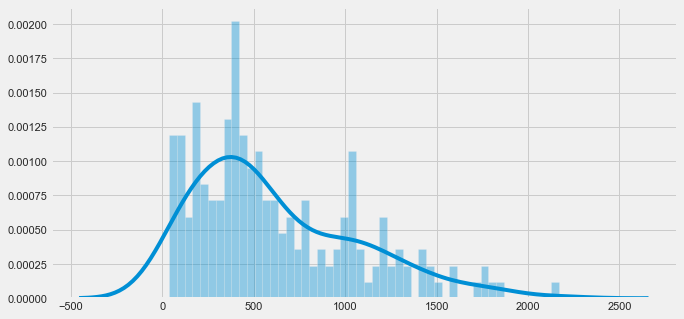

In [25]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [26]:
split_statement_df = get_split_df(proc_statement_df)
split_statement_df.tail(10)

,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
840,statement,2020-03-15,FOMC Statement,Jerome Powell,61,-1.0,0.0,2020-04-29,at this meeting In a related set of actions to support the credit needs of households and businesses the Federal Reserve announced measures related to the discount window intraday credit bank capi...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
841,statement,2020-03-23,FOMC Statement,Jerome Powell,200,NaN,NaN,2020-04-29,The Federal Open Market Committee is taking further actions to support the flow of credit to households and businesses by addressing strains in the markets for Treasury securities and agency mortg...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
842,statement,2020-03-23,FOMC Statement,Jerome Powell,200,NaN,NaN,2020-04-29,range of to percent The Committee directs the Desk to increase the System Open Market Account holdings of Treasury securities and agency mortgage backed securities MBS in the amounts needed to sup...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
843,statement,2020-03-23,FOMC Statement,Jerome Powell,88,NaN,NaN,2020-04-29,of Treasury securities held outright in the System Open Market Account that are available for such operations and by a per counterparty limit of billion per day The Committee directs the Desk to c...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
844,statement,2020-03-31,FOMC Statement,Jerome Powell,200,NaN,NaN,2020-04-29,The Federal Reserve on Tuesday announced the establishment of a temporary repurchase agreement facility for foreign and international monetary authorities FIMA Repo Facility to help support the sm...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
845,statement,2020-03-31,FOMC Statement,Jerome Powell,99,NaN,NaN,2020-04-29,securities in the open market It should also serve along with the U S dollar liquidity swap lines the Federal Reserve has established with other central banks to help ease strains in global U S do...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the c

In [27]:
# Drop 'text_sections'
proc_statement_df.drop(columns=['text_sections'], inplace=True)
split_statement_df.drop(columns=['text_sections'], inplace=True)

## Minutes DataFrame

In [28]:
minutes_df.head()

,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes


In [29]:
# Check what kind of sections are in common

a = minutes_df.contents.str.lower().str.count('staff economic outlook')
b = minutes_df.contents.str.lower().str.count('developments in financial markets')
c = minutes_df.contents.str.lower().str.count('staff review of the economic situation')
d = minutes_df.contents.str.lower().str.count('staff review of the financial situation')
e = minutes_df.contents.str.lower().str.count('participants\' views on current condition')
f = minutes_df.contents.str.lower().str.count('committee policy action')
g = minutes_df.contents.str.lower().str.count('voting for this action')

pd.DataFrame({'date': minutes_df['date'], 'a': a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g})

#[re.findall("Voting for this action".lower(), text.lower()) for text in  minutes_df['contents']]


,date,a,b,c,d,e,f,g
0,1993-02-03,0,0,0,0,0,0,0
1,1993-03-23,0,0,0,0,0,0,0
2,1993-05-18,0,0,0,0,0,0,0
3,1993-07-07,0,0,0,0,0,0,0
4,1993-08-17,0,0,0,0,0,0,0
5,1993-09-21,0,0,0,0,0,0,0
6,1993-11-16,0,0,0,0,0,0,0
7,1993-12-21,0,0,0,0,0,0,0
8,1994-02-04,0,1,0,0,0,0,0
9,1994-03-22,0,0,0,0,0,0,0


Sections are added from time to time. For example, quarterly economic forcast started in 2011. Leave manually handling those for now, take another approach to filter sentenses by length and key words here.

In [30]:
# Reorganize the dataframe
dict = {
    'type': "minutes",
    'date': minutes_df['date'],
    'title': minutes_df['title'],
    'speaker': minutes_df['speaker'],
    'word_count': minutes_df['contents'].map(get_word_count),
    'decision': minutes_df['date'].map(get_rate_change),
    'rate': minutes_df['date'].map(get_rate),
    'next_meeting': minutes_df['date'].map(get_next_meeting_date),
    'text': minutes_df['contents'].map(lambda x: x.replace('\n','').replace('\r','')),
    'text_sections': minutes_df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
    'org_text': minutes_df['contents']
}

proc_minutes_df = pd.DataFrame(dict)
print("No rate decision found: ", proc_minutes_df['decision'].isnull().sum())
print("Shape of the dataframe: ", proc_minutes_df.shape)
#proc_minutes_df.dropna(subset=['decision'], axis=0, inplace=True)
proc_minutes_df.head(10)

No rate decision found:  41
Shape of the dataframe:  (226, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,10241,0.0,3.00,1993-02-18,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,5792,0.0,3.00,1993-05-18,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00 ...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,5001,0.0,3.00,1993-07-07,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,7064,0.0,3.00,1993-08-17,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. a...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. ...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,4679,0.0,3.00,1993-09-21,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a.m...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a....","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
5,minutes,1993-09-21,FOMC Meeting Minutes,Alan Greenspan,4995,0.0,3.00,1993-10-05,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, September 21, 1993, at 9:00 ...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, September 21, 1993, at 9:00...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve Syst

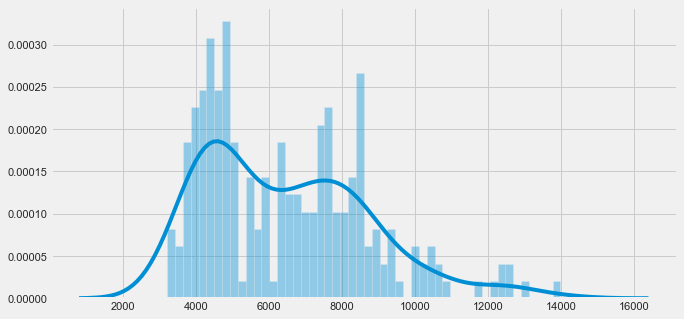

In [31]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [32]:
# Keep sections having keywords and long enough
proc_minutes_df = remove_short_nokeyword(proc_minutes_df)
proc_minutes_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,370,0.0,3.00,1993-02-18,"The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quarte...","[The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quart...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,994,0.0,3.00,1993-05-18,"In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late ...","[In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,544,0.0,3.00,1993-08-17,"In conformance with the usual practice at meetings when the Committee considers its longer-run objectives for growth of the monetary and debt aggregates, the members of the Committee and t...","[In conformance with the usual practice at meetings when the Committee considers its longer-run objectives for growth of the monetary and debt aggregates, the members of the Committee and ...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,476,0.0,3.00,1993-09-21,"Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped slig...","[Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped sli...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
5,minutes,1993-09-21,FOMC Meeting Minutes,Alan Greenspan,319,0.0,3.00,1993-10-05,"The information reviewed by the Committee at this meeting suggested that economic activity, adjusted for the temporary depressing effects of the flood in the Midwest, was continuing to ...","[The information reviewed by the Committee at this meeting suggested that economic activity, adjusted for the temporary depressing effects of the flood in the Midwest, was continuing to ...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, September 21, 1993, ..."
6,minutes,1993-11-16,FOMC Meeting Minutes,Alan Greenspan,390,0.0,3.00,1993-12-21,"M2 registered a relatively strong advance in September, but growth slowed again in October. The September pickup partly reflected an unexpected surge in the volatile overnight repurchase a...","[M2 registered a relatively strong advance in September, but growth slowed again in October. The September pickup partly reflected an unexpected surge in the volatile overnight repurchase ...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reser

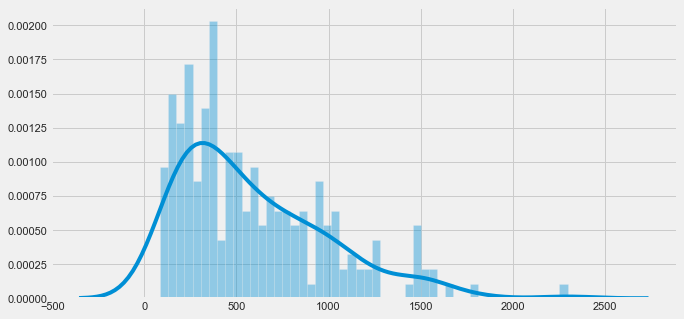

In [33]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [34]:
split_minutes_df = get_split_df(proc_minutes_df)
print(split_minutes_df.shape)
split_minutes_df.tail(10)


(868, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
858,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,200,-1.0,0.0,2020-04-29,Developments in Financial Markets and Open Market OperationsThe System Open Market Account SOMA manager first reviewed developments in domestic and global financial markets Financial markets remai...,[Developments in Financial Markets and Open Market OperationsThe System Open Market Account (SOMA) manager first reviewed developments in domestic and global financial markets. Financial markets r...,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
859,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,200,-1.0,0.0,2020-04-29,upcoming scheduled meeting following the basis point reduction in the target range in early March In addition market participants reportedly anticipated that the Committee would announce additiona...,[Developments in Financial Markets and Open Market OperationsThe System Open Market Account (SOMA) manager first reviewed developments in domestic and global financial markets. Financial markets r...,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
860,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,200,-1.0,0.0,2020-04-29,signs of funding strains late in the intermeeting period The rates on unsecured CP and negotiable certificates of deposit with maturities exceeding one month increased sharply relative to OIS rate...,[Developments in Financial Markets and Open Market OperationsThe System Open Market Account (SOMA) manager first reviewed developments in domestic and global financial markets. Financial markets r...,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
861,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,200,-1.0,0.0,2020-04-29,public Commercial and industrial loan growth was modest Credit quality indicators for nonfinancial corporations had been solid earlier in the quarter but deteriorated following the escalation of t...,[Developments in Financial Markets and Open Market OperationsThe System Open Market Account (SOMA) manager first reviewed developments in domestic and global financial markets. Financial markets r...,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
862,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,193,-1.0,0.0,2020-04-29,demand Participants discussed some of the possible communications challenges associated with the Committee's policy decisions at this meeting Several participants noted that it would be important ...,[Developments in Financial Markets and Open Market OperationsThe System Open Market Account (SOMA) manager first reviewed developments in domestic and global financial markets. Financial markets r...,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
863,minutes,2020-04-29,FOMC Meeting Minutes,Jerome Powell,200,0.0,0.0,NaT,Conditions in money markets had improved over recent weeks The intense strains across a range of short term funding markets that emerged in March had subsided The expansion of Federal Reserve repu...,[Conditions in money markets had improved over recent weeks. The intense strains across a range of short-term funding markets that emerged in March had subsided. The expansion of Federal Reserve r...,"The Federal Re

In [35]:
# Drop 'text_sections'
proc_minutes_df.drop(columns=['text_sections'], inplace=True)
split_minutes_df.drop(columns=['text_sections'], inplace=True)

## Press Conference Script DataFrame
Press Conference transcripts are available only from 2011

In [36]:
# Sample
print(presconf_script_df['contents'][2])

CHAIRMAN BERNANKE.  Good afternoon, everybody.  Welcome.  In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy.  I will then be glad to take your questions.   As indicated in its statement, the Committee decided today to maintain the policies that were initiated at previous meetings.  In particular, the Committee is keeping the target range for the federal funds rate at 0 to ¼ percent and continues to anticipate that economic conditions are likely to warrant exceptionally low levels for the federal funds rate at least through mid-2013. The Committee will continue the program that we announced in September to extend the average maturity of the Federal Reserve’s holdings of securities by purchasing longer-term Treasury securities and selling an equal amount of shorter-term Treasury securities.  Our purchases of longer-term securities exert downward pressures on longer-term interest rates; at the same time, our guidance about the lik

In [37]:
# Reorganize the dataframe
dict = {
    'type': "presconf_script",
    'date': presconf_script_df['date'],
    'title': presconf_script_df['title'],
    'speaker': presconf_script_df['speaker'],
    'word_count': presconf_script_df['contents'].map(get_word_count),
    'decision': presconf_script_df['date'].map(get_rate_change),
    'rate': presconf_script_df['date'].map(get_rate),
    'next_meeting': presconf_script_df['date'].map(get_next_meeting_date),
    'text': presconf_script_df['contents'].map(lambda x: x.replace('\n','').replace('\r','')),
    'text_sections': presconf_script_df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
    'org_text': presconf_script_df['contents']
}

proc_presconf_script_df = pd.DataFrame(dict)
print("No rate decision found: ", proc_presconf_script_df['decision'].isnull().sum())
print("Shape of the dataframe: ", proc_presconf_script_df.shape)
#proc_presconf_script_df.dropna(subset=['decision'], axis=0, inplace=True)
proc_presconf_script_df.head(10)


No rate decision found:  16
Shape of the dataframe:  (43, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,8763,NaN,NaN,2015-01-28,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,7364,NaN,NaN,2015-01-28,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...","[CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections...","CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ..."
2,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,7360,NaN,NaN,2015-01-28,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...","[CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to tak...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take..."
3,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,10135,NaN,NaN,2015-01-28,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,[CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals ...,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...
4,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,7680,NaN,NaN,2015-01-28,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...","[CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in t...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th..."
5,presconf_script,2012-06-20,FOMC Press Conference Transcript,Ben Bernanke,7218,NaN,NaN,2015-01-28,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then place the Committee’s appropriate path of moneta...","[CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee an

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [38]:
script_data_list = []

for i, row in tqdm(proc_presconf_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_presconf_script_df.columns

presconf_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
presconf_script_speaker_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,1617,NaN,NaN,2015-01-28,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,64,NaN,NaN,2015-01-28,"Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarter GDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you see as th...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,198,NaN,NaN,2015-01-28,"You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,56,NaN,NaN,2015-01-28,"Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And could...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,322,NaN,NaN,2015-01-28,"Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’ll...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
5,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,57,NaN,NaN,2015-01-28,"Mr. Chairman, first, thanks for doing this. This is a tremendous development. There are critics who say that Fed policy has driven down the value of the dollar, and a lower value to the dollar ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next

(2018, 11)


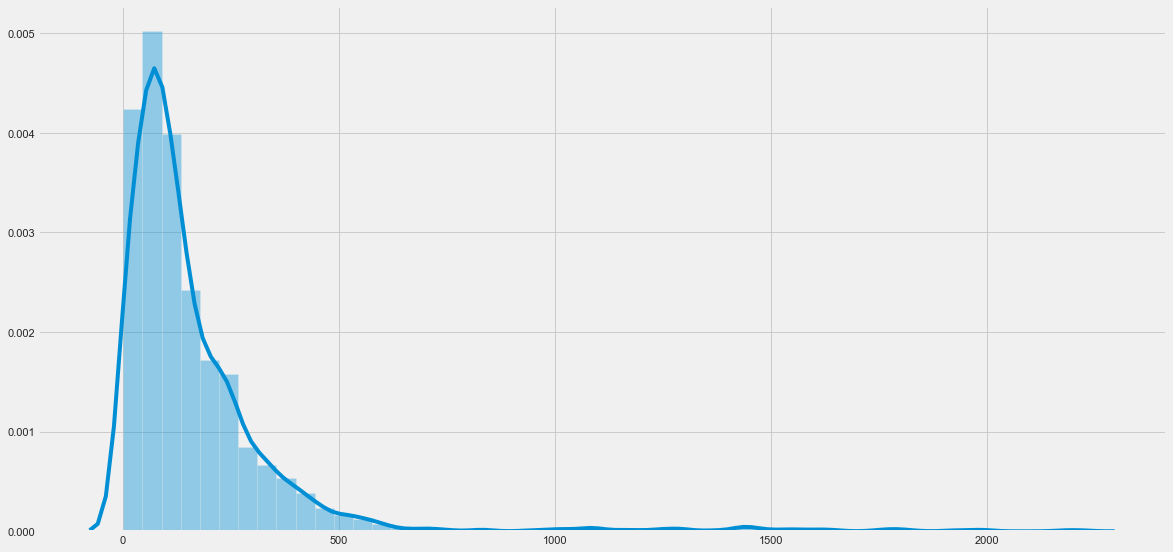

In [39]:
print(presconf_script_speaker_df.shape)
sns.distplot(presconf_script_speaker_df["word_count"].values, bins=50)

In [40]:
# Filter to have only chairperson's speak

tmp_list = []
for i, row in presconf_script_speaker_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = presconf_script_speaker_df.columns
presconf_script_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
presconf_script_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,1617,NaN,NaN,2015-01-28,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,198,NaN,NaN,2015-01-28,"You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,322,NaN,NaN,2015-01-28,"Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’ll...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,207,NaN,NaN,2015-01-28,"Thanks, Steve. First, I should start by saying that the Secretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar and Secretary Geithner had some words yesterday. ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,167,NaN,NaN,2015-01-28,"Well, the dollar—the dollar fluctuates. One factor, for example, that has caused fluctuations that have been quite extreme during the crisis has been the safe-haven effect. So, for example, dur...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
5,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,511,NaN,NaN,2015-01-28,"Sure. Thanks, Jon. So, first of all, gasoline prices obviously have risen quite significantly. And we, of course, are watching that carefully, that higher gas prices are absolutely creating a ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next t

Before:  (1035, 11)



After (43, 11)


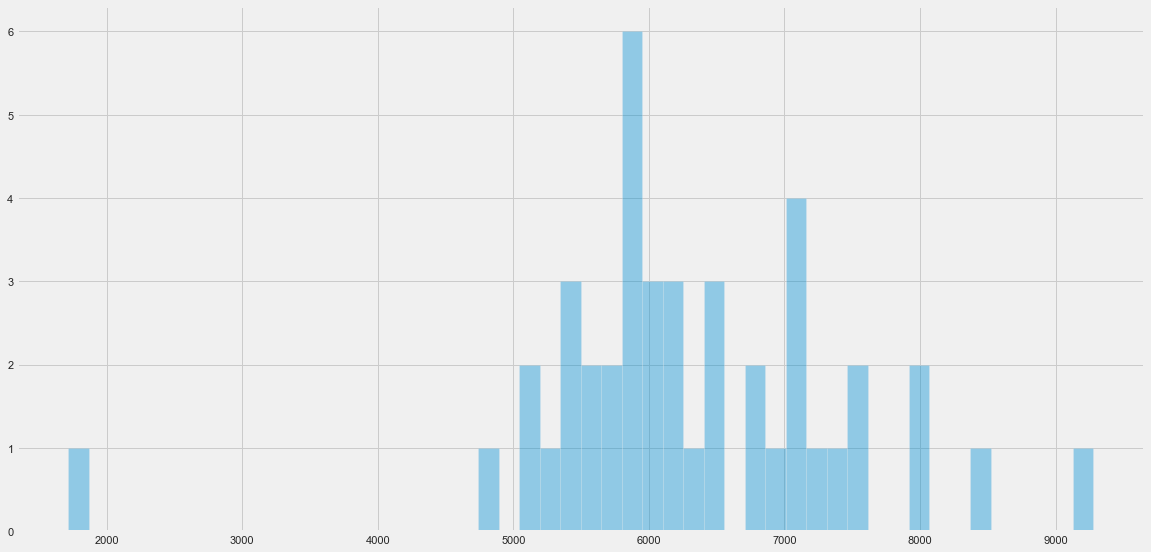

In [41]:
# Combine scripts of the same speaker for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', presconf_script_chair_df.shape)

for i, row in tqdm(presconf_script_chair_df.iterrows()):
    if (row['date'] == tmp_date) and (row['speaker'] == tmp_speaker):
        tmp_data[-1]['text'] += row['text']
        tmp_data[-1]['word_count'] += row['word_count']
    else:
        tmp_date = row['date']
        tmp_speaker = row['speaker']
        tmp_data.append(row)

presconf_script_chair_day_df = pd.DataFrame(tmp_data)

print('After', presconf_script_chair_day_df.shape)
presconf_script_chair_day_df.head()

sns.distplot(list(presconf_script_chair_day_df['word_count']), bins=50, kde=False)

### Split contents to max 200 words

In [42]:
presconf_script_split_df = get_split_df(presconf_script_chair_day_df)
print(presconf_script_split_df.shape)
presconf_script_split_df.tail()


(1813, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
1808,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,200,0.0,0.0,NaT,as they were in and So in terms of the labor market the the risk to of damage to people s skills and their careers and their lives is a function of time to some extent So the longer one is unemplo...,[CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United S...,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United St...
1809,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,200,0.0,0.0,NaT,but we do have the tools to to do what we can to to keep people in touch with the labor force and working and also out of insolvency too It doesn t seem fair that people should lose everything the...,[CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United S...,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United St...
1810,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,200,0.0,0.0,NaT,unusual time And so but in terms of the of the way to think about that money I think that s really a question for the Treasury Department You know we are we set up the facilities and we work very ...,[CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United S...,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United St...
1811,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,200,0.0,0.0,NaT,who are really really just relying on their bank savings account earnings this is you know that s that s you re not going to benefit from low interest rates But we you know we have to look out for...,[CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United S...,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United St...
1812,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,108,0.0,0.0,NaT,are just exactly the things we re thinking about Right now we like the place we are We ve said that we ll keep our rates where they are until we re confident that the economy has weathered the eff...,[CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United S...,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United St...


In [43]:
# Drop text_sections
presconf_script_chair_day_df.drop(columns=['text_sections'], inplace=True)
presconf_script_split_df.drop(columns=['text_sections'], inplace=True)

## Meeting Script DataFrame

In [44]:
# Sample
print(meeting_script_df['contents'][2])

CHAIRMAN GREENSPAN.  Will  someone move  approval  of  theminutes  of  the  March  27th  meeting?

[SECTION]

MS.  SEGER.  I'll move  them.

[SECTION]

MR. KELLEY.  Second.

[SECTION]

CHAIRMAN GREENSPAN.  Without  objection.  Mr.  Cross,  would  youbring us  up  to  date  on  Desk operations?

[SECTION]

MR.  CROSS.  [Statement--see  Appendix.]

[SECTION]

CHAIRMAN GREENSPAN.  Questions  for  Mr.  Cross?  If  there  areno  questions,  would  somebody like  to  move  the  ratification  of  histransactions  since  the  last  meeting?

[SECTION]

VICE  CHAIRMAN  CORRIGAN.  So  moved.

[SECTION]

SPEAKER(?).  Second.

[SECTION]

CHAIRMAN  GREENSPAN.  Without  objection.  Mr.  Sternlight.

[SECTION]

MR.  STERNLIGHT.  Thank you,  Mr.  Chairman.  [Statement--seeAppendix.]

[SECTION]

CHAIRMAN  GREENSPAN.  Are  there  any  questions  for Mr.Sternlight?

[SECTION]

MR.  HOSKINS.  Peter,  in  March  I asked  about  collateral  toback  the  Federal  Reserve  notes.  You thought  there might  be

In [45]:
# Reorganize the dataframe
dict = {
    'type': "meeting_script",
    'date': meeting_script_df['date'],
    'title': meeting_script_df['title'],
    'speaker': meeting_script_df['speaker'],
    'word_count': meeting_script_df['contents'].map(get_word_count),
    'decision': meeting_script_df['date'].map(get_rate_change),
    'rate': meeting_script_df['date'].map(get_rate),
    'next_meeting': meeting_script_df['date'].map(get_next_meeting_date),
    'text': meeting_script_df['contents'].map(lambda x: x.replace('\n','').replace('\r','')),
    'text_sections': meeting_script_df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
    'org_text': meeting_script_df['contents']
}

proc_meeting_script_df = pd.DataFrame(dict)
print("No rate decision found: ", proc_meeting_script_df['decision'].isnull().sum())
print("Shape of the dataframe: ", proc_meeting_script_df.shape)
#proc_meeting_script_df.dropna(subset=['decision'], axis=0, inplace=True)
proc_meeting_script_df.head(10)


No rate decision found:  35
Shape of the dataframe:  (200, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,meeting_script,1990-02-07,FOMC Meeting Transcript,Alan Greenspan,27040,0.0,8.25,1990-03-27,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.][SECTION]MESSRS. PRELL & TRUMAN. [Statements--see Appendix.][SECTION]CHAIRMAN GREENSPAN. Questions for the gentlemen?[SECTION]MR. ...,"[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
1,meeting_script,1990-03-27,FOMC Meeting Transcript,Alan Greenspan,39963,0.0,8.25,1990-04-11,CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?[SECTION]MR. JOHNSON. Second.[SECTION]SPEAKER(?). It's too early to tell![SECTION]CH...,"[CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?, MR. JOHNSON. Second., SPEAKER(?). It's too early to tell!, CHAIRMAN GREENSPAN. C...",CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?\n\n[SECTION]\n\nMR. JOHNSON. Second.\n\n[SECTION]\n\nSPEAKER(?). It's too early to ...
2,meeting_script,1990-05-15,FOMC Meeting Transcript,Alan Greenspan,17304,0.0,8.25,1990-07-03,CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?[SECTION]MS. SEGER. I'll move them.[SECTION]MR. KELLEY. Second.[SECTION]CHAIRMAN GREENSPAN. Wi...,"[CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?, MS. SEGER. I'll move them., MR. KELLEY. Second., CHAIRMAN GREENSPAN. Without objection. M...",CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move them.\n\n[SECTION]\n\nMR. KELLEY. Second.\n\n[SECTION]\n\...
3,meeting_script,1990-07-03,FOMC Meeting Transcript,Alan Greenspan,26864,0.0,8.25,1990-08-21,"CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--[SECTION]VICE CHAIRMAN CORRIGAN. So move.[SECTION]SPEAKER(?). Second.[SECTION...","[CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--, VICE CHAIRMAN CORRIGAN. So move., SPEAKER(?). Second., CHAIRMAN GREENSPAN....","CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--\n\n[SECTION]\n\nVICE CHAIRMAN CORRIGAN. So move.\n\n[SECTION]\n\nSPEAKER(?). ..."
4,meeting_script,1990-08-21,FOMC Meeting Transcript,Alan Greenspan,22419,0.0,8.00,1990-09-07,"CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes.[SECTION]SPEAKER(?). So move.[SECTION]CHAIRMAN GREENSPAN. Is there a se...","[CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes., SPEAKER(?). So move., CHAIRMAN GREENSPAN. Is there a second?, SPEAKE...","CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes.\n\n[SECTION]\n\nSPEAKER(?). So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. ..."
5,meeting_script,1990-10-02,FOMC Meeting Transcript,Alan Greenspan,29203,0.0,8.00,1990-11-13,"CHAIRMAN GREENSPAN. Good morning, everyone. Would somebodykindly move the minutes of the last FOMC meeting?[SECTION]MS. SEGER. I'll move.[SECTION]CHAIRMAN GREENSPAN. Is there a second...","[CHAIRMAN GREENSPAN. Good morning, everyone. Would somebodykindly move the minutes of the last FOMC meeting?, MS. SEGER. I'll move., CHAIRMAN GREENSPAN. Is there a second? Without o...","CHAIRMAN GREENSPAN. Good morning, everyone. Would somebodykindly move the minutes of the last FOMC meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Is ..."

(200, 11)


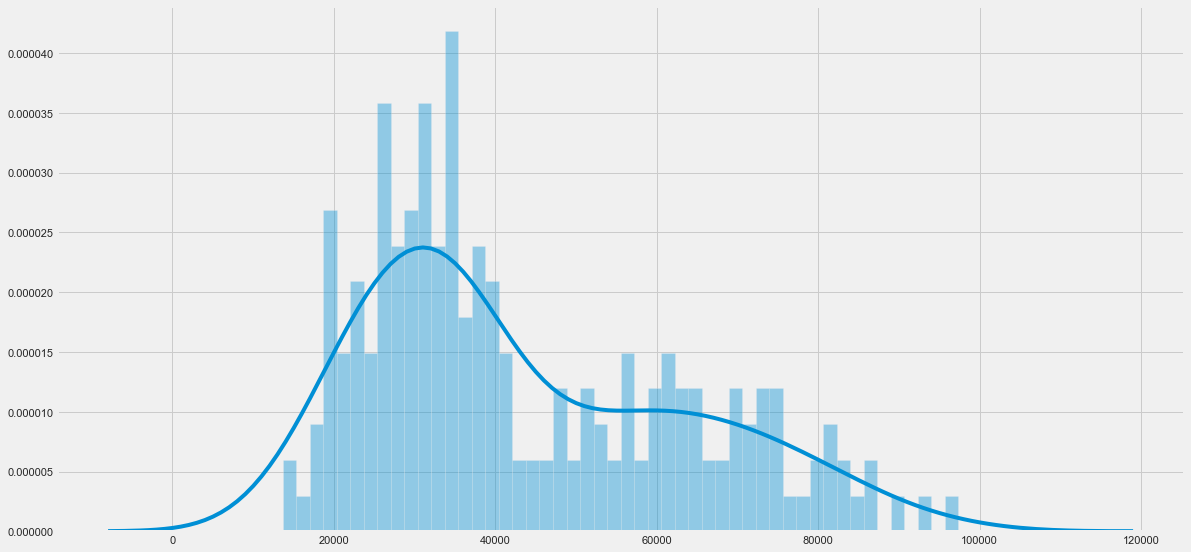

In [46]:
print(proc_meeting_script_df.shape)
sns.distplot(proc_meeting_script_df["word_count"].values, bins=50)

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [47]:
script_data_list = []

for i, row in tqdm(proc_meeting_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_meeting_script_df.columns

meeting_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
meeting_script_speaker_df

not matched:  MR.  [STERN(?)]  We  don't  have  a difference  in  interpretation.
1990-02-07 00:00:00

not matched:  MR. BERNARD.Chairman  Greenspan Vice  Chairman  Corrigan Governor Angell President Boehne President Boykin President Hoskins Governor  Johnson Governor Kelley Governor  LaWare Governor  Seger President  Stern YesYesYesYesYesYesYesYesYesNoYes
1990-02-07 00:00:00

not matched:  SPEAKER(?).  I'm  ready  for  lunch!
1990-02-07 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman Corrigan YesYes2/6-7/90-41-Governor  Angell President  Boehne President  Boykin President Hoskins Governor  Johnson Governor Kelley Governor  LaWare Governor  Seger President  Stern NoYesYesYesYesYesYesNoYes
1990-02-07 00:00:00

not matched:  MR. BERNARD.Chairman  Greenspan Vice  Chairman  Corrigan Governor Angell President Boehne President Boykin President Hoskins Governor  Johnson Governor Kelley Governor  LaWare Governor  Seger President  Stern YesYesYesYesNoNoYesYesYesNoYes
19

not matched:  SPEAKER(?).  I move  them.
1991-02-06 00:00:00

not matched:  MR.  PARRY(?).  It's  a  fifty percent  change.
1991-02-06 00:00:00

not matched:  SPEAKER(?). [Unintelligible]  percent.
1991-02-06 00:00:00

not matched:  MR. BERNARD.Chairman Greenspan Vice  Chairman  Corrigan Governor  Angell President  Black President  Forrestal President  Keehn Governor  Kelley Governor  LaWare Governor Mullins President  Parry Governor  Seger YesYesYesYesNoYesYesYesYesYesYes
1991-02-06 00:00:00

not matched:  SPEAKER(?).  Sterilizing!
1991-02-06 00:00:00

not matched:  MR.  BERNARD.Chairman  GreenspanVice  Chairman  CorriganGovernor  AngellPresident  BlackPresident  ForrestalPresident  KeehnGovernor  KelleyGovernor  LaWareGovernor  MullinsPresident  ParryGovernor  SegerYesYesYesYesYesYesYesYesYesYesYes
1991-02-06 00:00:00

not matched:  SPEAKER(?).  Second.
1991-03-26 00:00:00

not matched:  SPEAKER(?).  Why didn't  you  sell  those bonds before  they  lostvalue?
1991-03-26 00:00:00

not

not matched:  SPEAKER(?).  You're  right!
1992-05-19 00:00:00

not matched:  SPEAKER(?).  That's  better.
1992-05-19 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman  Corrigan Governor Angell President  Hoenig President  Jordan Governor  Kelley Governor  LaWare Governor  Lindsey President  Melzer Governor Mullins Governor  Phillips President  Syron YesYesYesYesYesYesYesYesYesYesYesYes
1992-05-19 00:00:00

not matched:  SPEAKER(?).  Payroll  [employment  growth]  has  been more  like300,000  so  far,  hasn't  it?
1992-07-01 00:00:00

not matched:  SPEAKER(?).  As  the  non-M2  economy!
1992-07-01 00:00:00

not matched:  SPEAKER(?).  If  it's  a bogey,  I'll  settle  for  that  any day.
1992-07-01 00:00:00

not matched:  SPEAKER(?).  Or  a double  bogey.
1992-07-01 00:00:00

not matched:  MR.  BERNARD.Chairman Greenspan Vice  Chairman Corrigan Governor  Angell President  Hoenig President  Jordan Governor  Kelley Governor  LaWare Governor  Lindsey President  Melzer 

not matched:  SPEAKER(?).  Second.
1994-05-17 00:00:00

not matched:  SPEAKER(?).  So  move.
1994-05-17 00:00:00

not matched:  SPEAKER(?).  Second.5/17/94-5-
1994-05-17 00:00:00

not matched:  SPEAKER(?).  Maybe  it's  because of  the  residents!
1994-05-17 00:00:00

not matched:  MR. BERNARD.Chairman Greenspan Vice  Chairman McDonough President Broaddus President Forrestal President Jordan Governor Kelley Governor LaWare Governor Lindsey President Parry Governor Phillips YesYesYesYesYesYesYesYesYesYes
1994-05-17 00:00:00

not matched:  END OF MEETING
1994-05-17 00:00:00

not matched:  SPEAKER(?).  Thank you!
1994-07-06 00:00:00

not matched:  SPEAKER(?).  So move.
1994-07-06 00:00:00

not matched:  SPEAKER(?).  So move.
1994-07-06 00:00:00

not matched:  SPEAKER(?).  Second.7/5-6/94-13-
1994-07-06 00:00:00

not matched:  MR. BERNARD.Chairman Greenspan Vice Chairman McDonough Governor Blinder President  Broaddus President  Forrestal President Jordan Governor  Kelley Governor  LaWare

not matched:  MR. BERNARD.Chairman Greenspan Vice  Chairman McDonough President Boehne President Jordan Governor Kelley Governor Lindsey President McTeer Governor Phillips President  Stern Governor Yellen YesYesYesYesYesYesYesYesYesYes
1996-01-31 00:00:00

not matched:  END OF MEETING
1996-01-31 00:00:00

not matched:  SPEAKER(?).  Move approval.
1996-03-26 00:00:00

not matched:  MR. BERNARD.Chairman Greenspan Vice  Chairman McDonough President Boehne President Jordan Governor  Kelley Governor  Lindsey President McTeer Governor  Phillips President  Stern Governor Yellen YesYesYesYesYesYesYesYesYesYes
1996-03-26 00:00:00

not matched:  END OF MEETING
1996-03-26 00:00:00

not matched:  SPEAKER(?).  So move.
1996-05-21 00:00:00

not matched:  MR. BERNARD.Chairman Greenspan Yes5/21/96-40-Vice Chairman McDonough President Boehne President Jordan Governor Kelley Governor Lindsey President McTeer Governor Phillips President  Stern Governor Yellen YesYesYesYesYesYesYesYesYes
1996-05-21 00:00

not matched:  END OF MEETING
1998-07-01 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman  McDonough Governor Ferguson Governor Gramlich President Hoenig President Jordan Governor Kelley Governor Meyer President Minehan President Poole Governor Rivlin YesYesYesYesYesNoYesYesYesYesYes
1998-08-18 00:00:00

not matched:  END OF MEETING
1998-08-18 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman  McDonough Governor  Ferguson Governor  Gramlich President Hoenig President Jordan Governor  Kelley Governor  Meyer President Minehan President Poole Governor  Rivlin YesYesYesYesYesYesYesYesYesYesYes
1998-09-29 00:00:00

not matched:  SPEAKER(?).  Let's run  quickly!
1998-09-29 00:00:00

not matched:  END OF MEETING
1998-09-29 00:00:00

not matched:  SPEAKER(?).  Second.
1998-11-17 00:00:00

not matched:  SPEAKER(?).  Second.
1998-11-17 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice Chairman  McDonough Governor Ferguson Governor  Gramlich

not matched:  END OF MEETING
2004-11-10 00:00:00

not matched:  SPEAKER(?).  So moved. 
2004-12-14 00:00:00

not matched:  SPEAKER(?).  Second. 
2004-12-14 00:00:00

not matched:  SPEAKER(?).  So moved. 
2004-12-14 00:00:00

not matched:  SPEAKER(?).  Can’t you call the group in the last few paragraphs voting members? 
2004-12-14 00:00:00

not matched:  SPEAKER(?).  That’s what he’s proposing. 
2004-12-14 00:00:00

not matched:  END OF MEETING
2004-12-14 00:00:00

not matched:  SPEAKER(?).  So moved.  
2005-02-02 00:00:00

not matched:  SPEAKER(?).  Yes.  So moved.    The Presidents have a dinner to attend.  I look forward to seeing you all tomorrow at 8:59 a.m.   [Laughter]  [Meeting recessed]    
2005-02-02 00:00:00

not matched:  END OF MEETING
2005-02-02 00:00:00

not matched:  SPEAKER(?).  Just so I’m clear, how would you suggest we correct it at the May meeting? 
2005-03-22 00:00:00

not matched:  SPEAKER(?).  What do you think we ought to do?  [Laughter] 
2005-03-22 00:00:00

no

,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,meeting_script,1990-02-07,FOMC Meeting Transcript,MESSRS. CROSS,4,0.0,8.25,1990-03-27,& STERNLIGHT. [Statements--see Appendix.],"[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
1,meeting_script,1990-02-07,FOMC Meeting Transcript,MESSRS. PRELL,4,0.0,8.25,1990-03-27,& TRUMAN. [Statements--see Appendix.],"[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
2,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,4,0.0,8.25,1990-03-27,Questions for the gentlemen?,"[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
3,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. JOHNSON,92,0.0,8.25,1990-03-27,"First to Mike: Given the fact that theinflation picture remains stable in spite of slower growth, I waslooking at the profits trend and it's down. There is quite a prof...","[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
4,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. PRELL,299,0.0,8.25,1990-03-27,"Well, there are a couple of pieces to that andthey are both areas in which researchers have argued a great deal andhave not reached definitive conclusions. One is the in...","[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
5,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. JOHNSON,288,0.0,8.25,1990-03-27,"Okay, thanks. A question for Ted on thedollar, and this is something I raised yesterday too [at the Boardbriefing]: I realize the dollar has depreciated from the peak in 198...","[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
6,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. TRUMAN,23,0.0,8.25,1990-03-27,"Well, several things. One point is thatinflation in Germany and Japan, of course, is lower than the averagethat is shown there, so that--","[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix

Some are not matching the defined patterns but those unmatched ones do not look importnant. Thus ignore them here.

In [48]:
# Filter by word count having 20 or more.
print("Before: ", meeting_script_speaker_df.shape)
meeting_script_speaker_df = meeting_script_speaker_df.loc[meeting_script_speaker_df['word_count'] >= 20]
print("After: ", meeting_script_speaker_df.shape)

Before:  (60529, 11)
After:  (30374, 11)


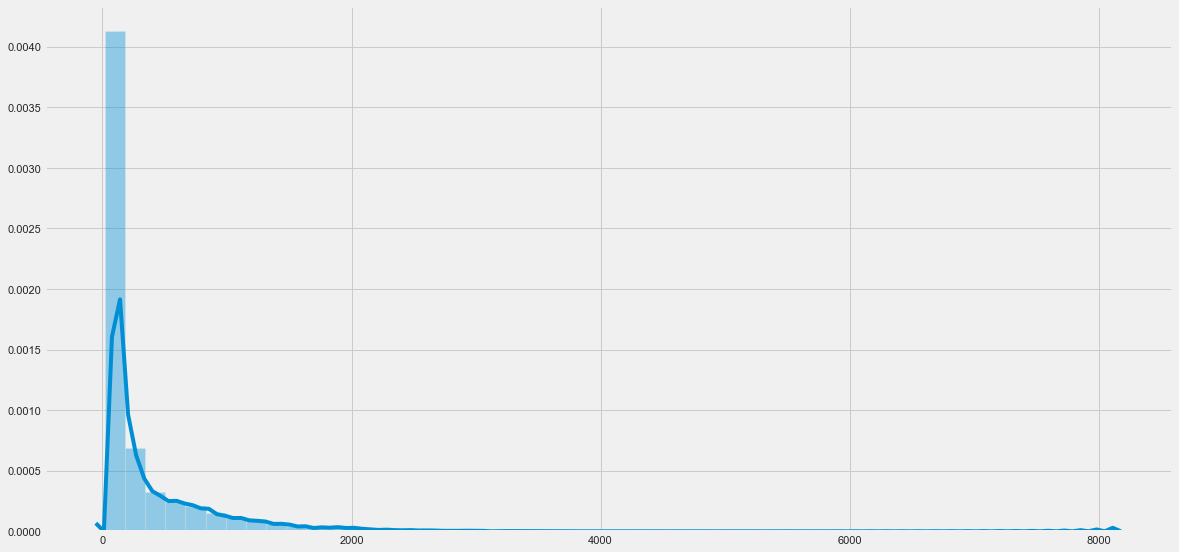

In [49]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

In [50]:
# Combine scripts for the same day.
meeting_script_speaker_df = meeting_script_speaker_df.groupby(['type', 'date', 'title', 'speaker', 'rate', 'decision', 'org_text'])['text'].apply(' '.join).reset_index()
meeting_script_speaker_df['word_count'] = meeting_script_speaker_df['text'].map(get_word_count)
meeting_script_speaker_df


,type,date,title,speaker,rate,decision,org_text,text,word_count
0,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,8.25,0.0,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...,There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abil...,903
1,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,8.25,0.0,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...,"And to the extent that the process mightaccelerate, as indeed it has in the past, we might find that--youknow, it says 1990 to 1994--they might not be full years. They ...",1220
2,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. ANGELL,8.25,0.0,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...,"You can move to amend, that's right. Mr.Chairman, the reason that I wanted to be earliest is because I reallyhave another suggestion. And if my suggestion gets a second, w...",163
3,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. ANGELL. My number for real GNP,8.25,0.0,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...,"is right underneath thestaff's at 1-1/2 percent real growth, but my nominal number isconsiderably less [than the staff's number]. I put nominal GNP justbarely above 4 percen...",681
4,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. BERNARD,8.25,0.0,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...,"I'm reading from line 59 of the draft directiveor from page 24 in the Bluebook: ""The Federal Open Market Committeeseeks monetary and financial conditions that will foster p...",256
5,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. BLACK,8.25,0.0,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...,"Mr. Chairman, Governor Johnson's questioningabout these real long-term interest rates prompted me to look at thefootnotes on Chart 15 down in the lower left-hand corner wh...",701
6,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. BOEHNE,8.25,0.0,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...,"My interpretation, Mr. Chairman, of what we didis that we took a straw vote and instead of doing it by raising handswe used our voices. And I view those two as largely equi...",61
7,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. BOYKIN,8.25,0.0,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...,"I remember several years ago I gave a verycomparable report and my good friend Ed Boehne leaned across the tableand said ""Boykin, that's a Texas problem."" So, maybe that's ju...",289
8,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. CROSS,8.25,0.0,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...,"Well, I certainly agree with Ted. I think whatis happening in the market reflects the v

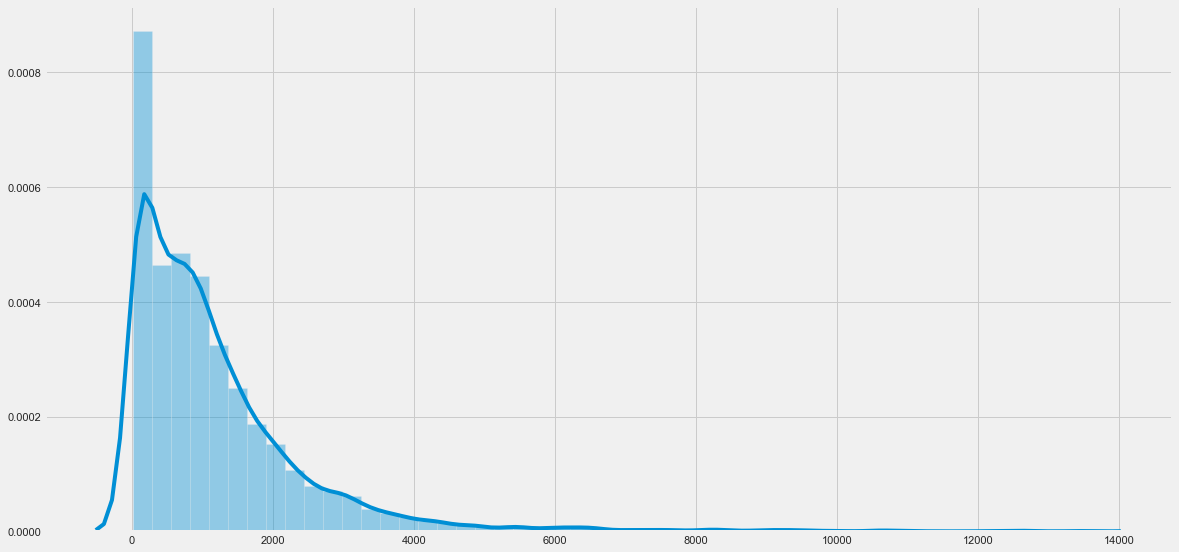

In [51]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [52]:
meeting_script_split_df = get_split_df(meeting_script_speaker_df)
print(meeting_script_split_df.shape)
meeting_script_split_df.tail()


(40875, 9)


,type,date,title,speaker,rate,decision,org_text,text,word_count
40870,meeting_script,2010-12-14,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY,0.0,0.0,"CHAIRMAN BERNANKE. Good morning, everybody. We welcome back First Vice President John Moore, who will again represent the Federal Reserve Bank of San Francisco. We’ll have a lunchtime briefing ...",borne out in a number of ways One way is the low score we received in the recent primary dealer survey conducted by the Desk even though the survey and its comments said the Chairman did a very go...,200
40871,meeting_script,2010-12-14,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY,0.0,0.0,"CHAIRMAN BERNANKE. Good morning, everybody. We welcome back First Vice President John Moore, who will again represent the Federal Reserve Bank of San Francisco. We’ll have a lunchtime briefing ...",s how the Committee expects this particular policy action is likely to work in practice I think the wrong way is to paint the consequences of the decision in more apocalyptic terms and or to creat...,200
40872,meeting_script,2010-12-14,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY,0.0,0.0,"CHAIRMAN BERNANKE. Good morning, everybody. We welcome back First Vice President John Moore, who will again represent the Federal Reserve Bank of San Francisco. We’ll have a lunchtime briefing ...",premium stems from uncertainty about our commitment to the program in other words would we be cowed by the criticism and thereby represents a loss of credibility on our part That being said it isn...,200
40873,meeting_script,2010-12-14,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY,0.0,0.0,"CHAIRMAN BERNANKE. Good morning, everybody. We welcome back First Vice President John Moore, who will again represent the Federal Reserve Bank of San Francisco. We’ll have a lunchtime briefing ...",Overall my policy view hasn t changed The LSAP program still makes sense and it s helping at the margin We have damaged its effectiveness to some degree I think it s important in reaching this con...,200
40874,meeting_script,2010-12-14,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY,0.0,0.0,"CHAIRMAN BERNANKE. Good morning, everybody. We welcome back First Vice President John Moore, who will again represent the Federal Reserve Bank of San Francisco. We’ll have a lunchtime briefing ...",the small changes contemplated in alternative B are right They acknowledge some of the intermeeting data We still have a long way to go in terms of our dual mandate A very accommodative policy sta...,129


## Speech DataFrame

In [53]:
# Reorganize the dataframe
dict = {
    'type': "speech",
    'date': speech_df['date'],
    'title': speech_df['title'],
    'speaker': speech_df['speaker'],
    'word_count': speech_df['contents'].map(get_word_count),
    'decision': None,
    'rate': None,
    'next_meeting': speech_df['date'].map(get_next_meeting_date),
    'text': speech_df['contents'].map(lambda x: x.replace('\n','').replace('\r','')),
    'text_sections': speech_df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
    'org_text': speech_df['contents']
}

proc_speech_df = pd.DataFrame(dict)
print("No next meeting found: ", proc_speech_df['next_meeting'].isnull().sum())
print("Shape of the dataframe: ", proc_speech_df.shape)
#proc_speech_df.dropna(subset=['decision'], axis=0, inplace=True)
proc_speech_df.tail()


No next meeting found:  5
Shape of the dataframe:  (1461, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
1456,speech,2020-05-05,Welcoming Remarks for Investment Connection â Response to COVID-19: Colorado,Governor Lael Brainard,476,None,None,NaT,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
1457,speech,2020-05-13,Current Economic Issues,Chair Jerome H. Powell,1360,None,None,NaT,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
1458,speech,2020-05-21,U.S. Economic Outlook and Monetary Policy,Vice Chair Richard H. Clarida,1940,None,None,NaT,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
1459,speech,2020-05-21,Opening Remarks,Chair Jerome H. Powell,680,None,None,NaT,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
1460,speech,2020-05-21,Introductory Remarks for the Fed Listens panel on the COVID-19 pandemic,Governor Lael Brainard,564,None,None,NaT,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."


(1461, 11)


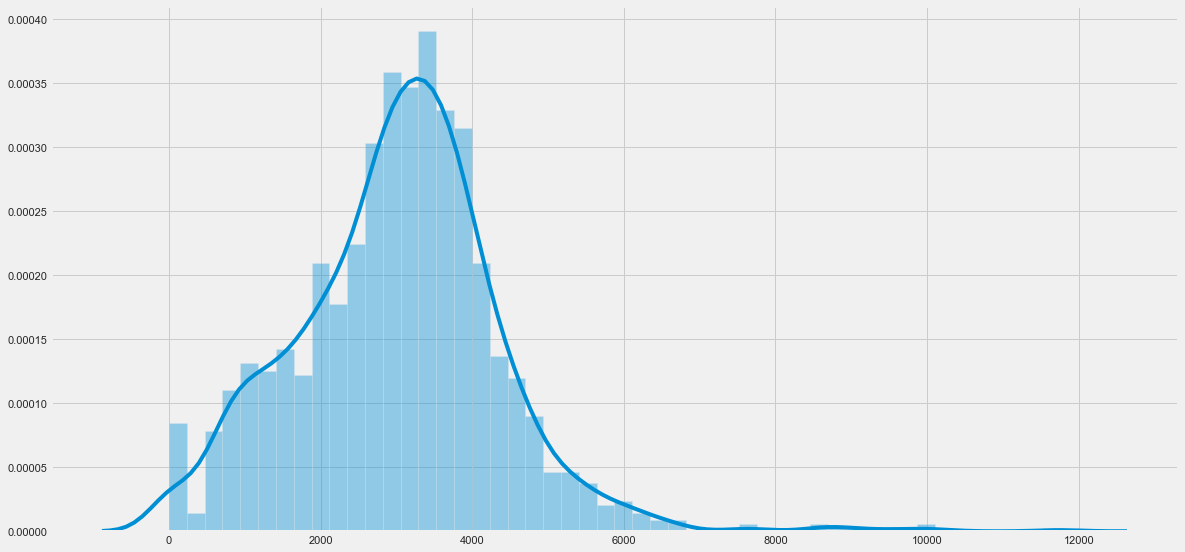

In [54]:
print(proc_speech_df.shape)
sns.distplot(proc_speech_df["word_count"].values, bins=50)

In [55]:
# Check records where speaker is null
proc_speech_df['speaker'].isnull().sum()

0

In [56]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_speech_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_speech_df.columns
speech_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)

print(speech_chair_df.shape)
speech_chair_df

(432, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,3211,None,None,1996-07-03,"Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996[SECTION][SECTION]I am honored to present...","[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-09-19,Regulation and electronic payment systems,Alan Greenspan,1988,None,None,1996-09-24,"Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996[SE...","[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
2,speech,1996-10-05,"Bank supervision, regulation, and risk",Alan Greenspan,2401,None,None,1996-11-13,"Remarks by Chairman Alan GreenspanBank supervision, regulation, and riskAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii October 5, 1996[SECTION][SECTION]You may well...","[Remarks by Chairman Alan GreenspanBank supervision, regulation, and riskAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii October 5, 1996, , You may well wonder why a...","Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\..."
3,speech,1996-10-07,U.S. Treasury securities market: Lessons from Alexander Hamilton,Alan Greenspan,1119,None,None,1996-11-13,"Remarks by Chairman Alan GreenspanU.S. Treasury securities market: Lessons from Alexander HamiltonAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, New Yor...","[Remarks by Chairman Alan GreenspanU.S. Treasury securities market: Lessons from Alexander HamiltonAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, New Yo...","Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N..."
4,speech,1996-10-16,Technological advances and productivity,Alan Greenspan,1783,None,None,1996-11-13,"Remarks by Chairman Alan GreenspanTechnological advances and productivityAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New YorkOctober 16, 1996[SECTION][SECTION]It is a ...","[Remarks by Chairman Alan GreenspanTechnological advances and productivityAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New YorkOctober 16, 1996, , It is a pleasure to b...","Remarks by Chairman Alan Greenspan\nTechnological advances and productivity\r\nAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New York\r\nOctober 16, 1996\n\n[SECTION]\n\..."
5,speech,1996-11-18,Banking in the global marketplace,Alan Greenspan,6015,None,None,1996-12-17,[SECTION]Banking in the Global Marketplace[SECTION]It is again a pleasure to be here in Tokyo at the invitation of the Bank of Japan. Tokyo's role as one of the world's key financial centers depen...,"[, Banking in the Global Marketplace, It is again a pl

### Split contents to max 200 words

In [57]:
speech_split_df = get_split_df(speech_chair_df)
speech_split_df.reset_index(drop=True, inplace=True)
print(speech_split_df.shape)
speech_split_df


(7758, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,None,None,1996-07-03,Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors Stockholm SwedenJune SECTION SECTION I am honored to present the William...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,None,None,1996-07-03,a successful senior bank supervisor better than Bill Taylor Well known for this integrity tenacity and professional dedication Bill demanded the best from himself and from those around him He unde...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
2,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,None,None,1996-07-03,becoming increasingly integrated and complex Banking has become more sophisticated the volume of transactions has multiplied and competitive pressures have grown These developments reflect the inc...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
3,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,None,None,1996-07-03,discuss the interaction of governments and central banks with private commercial banks in free economies in terms of risk sharing By articulating and understanding that relationship we may have a ...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
4,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,None,None,1996-07-03,our financial systems from the earliest times certainly since Renaissance goldsmiths discovered that lending out deposited gold was feasible and profitable Stockholm itself recognized the value of...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
5,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,None,None,1996-07-03,or market turmoil that affects broad segments of an economy and is not the consequence of the imprudence of individual banks Because of important roles banks and other financial intermediaries pla...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking

### Filter out by keyword

In [58]:
# Keep sections having keywords and long enough
speech_keyword_df = remove_short_nokeyword(speech_chair_df)
speech_keyword_df.reset_index(drop=True, inplace=True)
print(speech_keyword_df.shape)
speech_keyword_df


(142, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,speech,1996-12-06,Social security,Alan Greenspan,131,None,None,1996-12-17,"But, unless future taxes and/or benefits are sufficiently adjusted, there is no substitute for increased domestic savings and investment currently. To be sure, for relatively short periods of tim...","[But, unless future taxes and/or benefits are sufficiently adjusted, there is no substitute for increased domestic savings and investment currently. To be sure, for relatively short periods of ti...","\n\n[SECTION]\n\nI am privileged to accept the Union League of Philadelphia's Abraham Lincoln award. This is the first time I have been at the Union League in nearly four decades, but I am gratif..."
1,speech,1997-05-08,Current monetary policy,Alan Greenspan,92,None,None,1997-05-20,"With tight labor markets and little slack in product markets, we are led to conclude that significant persistent strength in the growth of nominal demand for goods and services, outstripping the l...","[With tight labor markets and little slack in product markets, we are led to conclude that significant persistent strength in the growth of nominal demand for goods and services, outstripping the ...",\n\n[SECTION]\n\nI am pleased to accept this years Charles Waldo Haskins Award and have the opportunity to address this distinguished audience on current monetary policy.\n\n[SECTION]\n\nA centra...
2,speech,1997-09-05,Rules vs. discretionary monetary policy,Alan Greenspan,240,None,None,1997-09-30,"Although the ultimate goals of policy have remained the same over these past fifteen years, the techniques used in formulating and implementing policy have changed considerably as a consequence of...","[Although the ultimate goals of policy have remained the same over these past fifteen years, the techniques used in formulating and implementing policy have changed considerably as a consequence o...","It is a pleasure to be at this conference marking the fifteenth anniversary of the Center for Economic Policy Research. The Center, by encouraging academic research into public policy and bringin..."
3,speech,1997-12-02,Growth and flexibility: Lessons from Asia,Alan Greenspan,565,None,None,1997-12-16,"Following the early post World War II period, policies generally fostering low levels of inflation and high rates of savings and investment--including investment in human capital through education...","[Following the early post World War II period, policies generally fostering low levels of inflation and high rates of savings and investment--including investment in human capital through educatio...","Dramatic advances in the global financial system have enabled us to materially improve the efficiency of the flows of capital and payments. Those advances, however, have also enhanced the ability..."
4,speech,1998-01-03,Problems of price measurement,Alan Greenspan,90,None,None,1998-02-04,"Even a moderate rate of inflation can hamper economic performance, as I have emphasized many times before; and although we do not have any recent experience, moderate rates of deflation would most...","[Even a moderate rate of inflation can hamper economic performance, as I have emphasized many times before; and although we do not have any recent experience, moderate rates of deflation would mos...","Problems of Price Measurement\n\n[SECTION]\n\nFor most of the past twenty years, the challenges confronting monetary policymakers centered on addressing the question of how inflation could be brou..."
5,speech,1998-02-27,Risk management in the global financial system,Alan Greenspan,243,None,None,1998-03-31,"Normally the presence of these factors would have produced a modest retrenchment, not the kind of discontinuous fall in confidence that leads to a vicious cycle of decline. But with a significant...","[Normally the presence of these factors would have produced a modest retrenchment, not the kind of discontinuous fall in confid

In [59]:
# Drop text_sections
speech_chair_df.drop(columns=['text_sections'], inplace=True)
speech_split_df.drop(columns=['text_sections'], inplace=True)
speech_keyword_df.drop(columns=['text_sections'], inplace=True)

## Testimony DataFrame

In [60]:
# Reorganize the dataframe
dict = {
    'type': "testimony",
    'date': testimony_df['date'],
    'title': testimony_df['title'],
    'speaker': testimony_df['speaker'],
    'word_count': testimony_df['contents'].map(get_word_count),
    'decision': None,
    'rate': None,
    'next_meeting': testimony_df['date'].map(get_next_meeting_date),
    'text': testimony_df['contents'].map(lambda x: x.replace('\n','').replace('\r','')),
    'text_sections': testimony_df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
    'org_text': testimony_df['contents']
}

proc_testimony_df = pd.DataFrame(dict)
print("No next meeting found: ", proc_testimony_df['next_meeting'].isnull().sum())
print("Shape of the dataframe: ", proc_testimony_df.shape)
#proc_testimony_df.dropna(subset=['decision'], axis=0, inplace=True)
proc_testimony_df.tail(10)


No next meeting found:  3
Shape of the dataframe:  (436, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
426,testimony,2019-07-10,Semiannual Monetary Policy Report to the Congress,Chair Jerome H. Powell,1649,None,None,2019-07-31,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
427,testimony,2019-09-12,Insurance Regulation,"Thomas Sullivan, Associate Director, Division of Supervision and Regulation",1624,None,None,2019-09-18,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
428,testimony,2019-09-25,Financial Stability,Governor Lael Brainard,2478,None,None,2019-10-04,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
429,testimony,2019-11-13,The Economic Outlook,Chair Jerome H. Powell,1678,None,None,2019-12-11,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
430,testimony,2019-11-20,Minority Depository Institutions,"Arthur Lindo, Deputy Director, Division of Supervision and Regulation",1271,None,None,2019-12-11,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
431,testimony,2019-12-04,Supervision and Regulation Report,Vice Chair for Supervision Randal K. Quarles,2104,None,None,2019-12-11,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and fi

(436, 11)


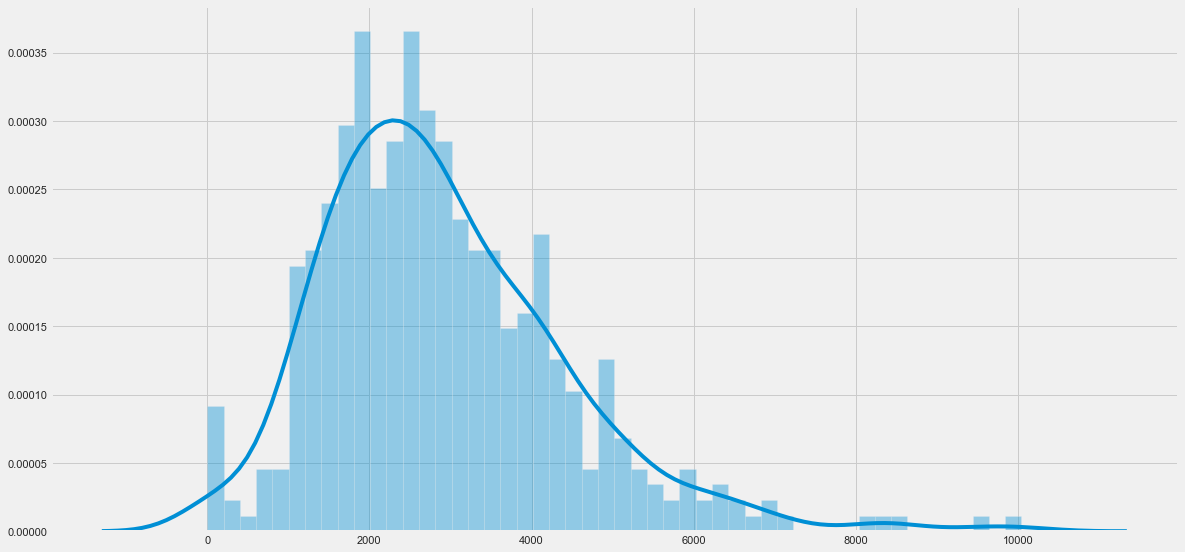

In [61]:
print(proc_testimony_df.shape)
sns.distplot(proc_testimony_df["word_count"].values, bins=50)

In [62]:
# Check records where speaker is null
proc_testimony_df['speaker'].isnull().sum()

0

In [63]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_testimony_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_testimony_df.columns
testimony_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
testimony_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,3372,None,None,1996-08-20,"Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996[SECTION]Before I t...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1996-07-26,Recent reports on Federal Reserve operations,Alan Greenspan,3764,None,None,1996-08-20,[SECTION][SECTION][SECTION][SECTION]I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevan...,"[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
2,testimony,1997-01-21,"January 21, 1997",Alan Greenspan,2937,None,None,1997-02-05,"Testimony of Chairman Alan GreenspanPerformance of the U.S. economyBefore the Committee on the Budget, United States SenateJanuary 21, 1997[SECTION]Mr. Chairman and members of the Committee, I am ...","[Testimony of Chairman Alan GreenspanPerformance of the U.S. economyBefore the Committee on the Budget, United States SenateJanuary 21, 1997, Mr. Chairman and members of the Committee, I am please...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th..."
3,testimony,1997-01-30,The comsumer price index,Alan Greenspan,2780,None,None,1997-02-05,"Testimony of Chairman Alan GreenspanThe consumer price indexBefore the Committee on Finance, United States SenateJanuary 30, 1997[SECTION]Mr. Chairman and members of the Committee, I appreciate th...","[Testimony of Chairman Alan GreenspanThe consumer price indexBefore the Committee on Finance, United States SenateJanuary 30, 1997, Mr. Chairman and members of the Committee, I appreciate the oppo...","Testimony of Chairman Alan Greenspan\nThe consumer price index\r\nBefore the Committee on Finance, United States Senate\r\nJanuary 30, 1997\n\n[SECTION]\n\nMr. Chairman and members of the Committe..."
4,testimony,1997-02-13,Modernization of the financial system,Alan Greenspan,4187,None,None,1997-03-25,"Testimony of Chairman Alan GreenspanModernization of the financial systemBefore the Subcommittee on Financial Institutions and Consumer Credit\tof the Committee on Banking and Financial Services,\...","[Testimony of Chairman Alan GreenspanModernization of the financial systemBefore the Subcommittee on Financial Institutions and Consumer Credit\tof the Committee on Banking and Financial Services,...",Testimony of Chairman Alan Greenspan\nModernization of the financial system\r\nBefore the Subcommittee on Financial Institutions and Consumer Credit\r\n\tof the Committee on Banking and Financial ...
5,testimony,1997-02-26,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,4221,None,None,1997-03-25,"Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate February 26, 1997[SECTION]I appr...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannua

### Split contents to max 200 words

In [64]:
testimony_split_df = get_split_df(testimony_chair_df)
testimony_split_df.reset_index(drop=True, inplace=True)
print(testimony_split_df.shape)
testimony_split_df


(3101, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,None,None,1996-08-20,Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking Housing and Urban Affairs U S Senate July SECTION Before I take this oppo...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,None,None,1996-08-20,the secondquarter industrial production rose at an annual rate of percent andmanufacturers are currently running their plant and equipment at utilization ratesthat are a touch above their postwar ...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,None,None,1996-08-20,possible reasons for this favorable inflation experienceand offering some thoughts about how long it might last SECTION Economic activity thus far this year has turned out to be better than manyan...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,None,None,1996-08-20,to settle back toward a more sustainable pace in themonths ahead SECTION First the bond markets have taken a turn toward restraint this year as theyhave responded to incoming data depicting an eco...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
4,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,None,None,1996-08-20,likely towane in coming quarters Consumer spending in the past few years has beenboosted as households have made up for the purchases of big ticket items that theyhad deferred during the recession...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
5,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,None,None,1996-08-20,conditions remain quite supportiveto domestic spending and the economies of many foreign countries are showingsigns of achieving more solid growth which should help support our export sales Moreov...,"[Testimony of Ch

### Filter out by keyword

In [65]:
# Keep sections having keywords and long enough
testimony_keyword_df = remove_short_nokeyword(testimony_chair_df)
testimony_keyword_df.reset_index(drop=True, inplace=True)
print(testimony_keyword_df.shape)
testimony_keyword_df


(77, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,168,None,None,1996-08-20,"The Recent Behavior of Inflation There are, to be sure, legitimate questions about how much margin in resourceutilization currently exists. Historically, current levels of slack, measured in ...","[The Recent Behavior of Inflation There are, to be sure, legitimate questions about how much margin in resourceutilization currently exists. Historically, current levels of slack, measured in...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1997-02-26,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,176,None,None,1997-03-25,"The unemployment rate, according to Board members and Bank presidents, should stay around 5-1/4 to 5-1/2 percent through the fourth quarter, consistent with their projections of measured ...","[The unemployment rate, according to Board members and Bank presidents, should stay around 5-1/4 to 5-1/2 percent through the fourth quarter, consistent with their projections of measured...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nFebruary 26, 1997\n\n[..."
2,testimony,1997-03-20,Performance of the U.S. economy,Alan Greenspan,160,None,None,1997-03-25,"Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly i...","[Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly ...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nJoint Economic Committee, United States Congress\r\n\r\nMarch 20, 1997\n\n[SECTION]\n\n\n\n[SECTION]\n\nMr. Chairman and me..."
3,testimony,1997-07-22,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,204,None,None,1997-08-19,"In contrast to the typical postwar business cycle, measured price inflation is lower now than when the expansion began and has shown little tendency to rebound of late, ...","[In contrast to the typical postwar business cycle, measured price inflation is lower now than when the expansion began and has shown little tendency to rebound of late,...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 22, 1997\n\n[SECT..."
4,testimony,1998-01-30,The current Asia crisis and the dynamics of international finance,Alan Greenspan,285,None,None,1998-02-04,"Once the recent crisis was triggered in early July with Thailand's forced abandonment of its exchange rate peg, it was apparently the lethal combination of pegged exchange rates, high leverage, we...","[Once the recent crisis was triggered in early July with Thailand's forced abandonment of its exchange rate peg, it was apparently the lethal combination of pegged exchange rates, high leverage, w...","Testimony of Chairman Alan Greenspan\nThe current Asia crisis and the dynamics of international finance\r\nBefore the Committee on Banking and Financial Services,\tU.S. House of Representatives\r\..."
5,testimony,1998-02-12,The current Asian crisis and the dynamics of international finance,Alan Greenspan,241,None,None,1998-03-31,"Normally the presence of these factors would have produced a modest retrenchment, not the kind of discontinuous fall in confidence that leads to a vicious cycle of decline. But with a significant...","[Normally the presence of these factors would have produced

In [66]:
# Drop text sections
testimony_chair_df.drop(columns=['text_sections'], inplace=True)
testimony_split_df.drop(columns=['text_sections'], inplace=True)
testimony_keyword_df.drop(columns=['text_sections'], inplace=True)

## Save the train data

In [67]:
text_no_split = pd.concat([proc_statement_df, 
                           proc_minutes_df, 
                           presconf_script_chair_day_df, 
                           meeting_script_speaker_df, 
                           speech_chair_df,
                           testimony_chair_df], sort=False)
text_no_split.reset_index(drop=True, inplace=True)
text_no_split.drop(columns=['org_text'], inplace=True)

text_split_200 = pd.concat([split_statement_df, 
                            split_minutes_df, 
                            presconf_script_split_df, 
                            meeting_script_split_df, 
                            speech_split_df, 
                            testimony_split_df], sort=False)
text_split_200.reset_index(drop=True, inplace=True)
text_split_200.drop(columns=['org_text'], inplace=True)

text_keyword = pd.concat([speech_keyword_df, 
                          testimony_keyword_df], sort=False)
text_keyword.reset_index(drop=True, inplace=True)
text_keyword.drop(columns=['org_text'], inplace=True)

In [70]:
def save_data(df, file_name, dir_name='../data/preprocessed/'):
    '''
    Save the given df to pickle file and csv file in the given directory.
    '''
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print("Data Saved to a pickle file in {} !".format(dir_name))

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print("Data Saved to a csv file in {} !".format(dir_name))
    

In [71]:
save_data(text_no_split, 'text_no_split')
save_data(text_split_200, 'text_split_200')
save_data(text_keyword, 'text_keyword')

Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
